In [1]:
%config Completer.use_jedi = False

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torchsummary import summary

In [22]:
from pytorch_unet import (dataset_generator,
                          data_generator,
                          losses,
                          utils,
                          unet)

In [5]:
BATCH_SIZE, TARGET_CHANNELS, HEIGHT, WIDTH, N_SAMPLES_TRAIN, N_SAMPLES_TEST   = 3, 6, 128, 128, 100, 10

In [6]:
# use the same transformations for train/val in this example
trfms = transforms.Compose([transforms.ToTensor()])

In [7]:
train_dataset = dataset_generator.CustomDataset(
    height=HEIGHT, 
    width=WIDTH, 
    n_samples=N_SAMPLES_TRAIN,
    transform=trfms)

test_dataset = dataset_generator.CustomDataset(
    height=HEIGHT, 
    width=WIDTH, 
    n_samples=N_SAMPLES_TRAIN,
    transform=trfms)

Image shape: (128, 128, 3)


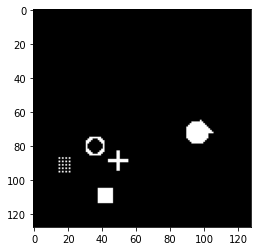

In [23]:
i = np.random.choice(N_SAMPLES_TRAIN)
img = utils.inverse_transform(train_dataset.__getitem__(i)[0])
print(f"Image shape: {img.shape}")
plt.imshow(img)
plt.show()

In [10]:
data_loaders = {
    "train": DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE, 
        shuffle=True),
    "test": DataLoader(
        dataset=test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False)}

In [11]:
for i, batch in enumerate(data_loaders["train"]):
    input_images, target_masks_true = batch
    break

In [12]:
target_masks_true.shape

torch.Size([3, 6, 128, 128])

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
model = unet.UNet(n_class=TARGET_CHANNELS)
model.to(device)
summary(model, input_size= input_images.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]          73,856
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
        MaxPool2d-14          [-1, 128,

In [15]:
input_images = input_images.to(device)
target_masks_true = target_masks_true.to(device)
target_masks_pred = model.forward(input_images)

In [16]:
target_masks_true.shape, target_masks_pred.shape

(torch.Size([3, 6, 128, 128]), torch.Size([3, 6, 128, 128]))

In [17]:
losses.dice_loss(target_masks_pred, target_masks_true, eps=0)

tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)

In [18]:
torch.nn.functional.binary_cross_entropy_with_logits(target_masks_pred, target_masks_true)

tensor(0.7286, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [19]:
losses.binary_cross_entropy_loss_with_logits(target_masks_pred, target_masks_true)

tensor(0.7286, device='cuda:0', grad_fn=<MeanBackward0>)

In [20]:
loss_metrics = dict(bce=0.0, dice=0.0, total=0.0)
x = losses.total_loss(target_masks_pred, target_masks_true, loss_metrics)
x

tensor(0.8532, device='cuda:0', grad_fn=<AddBackward0>)

In [21]:
loss_metrics

{'bce': 0.7286021113395691,
 'dice': 0.9778321385383606,
 'total': 0.8532171249389648}